## Morphological Calls(63x) by Post Patch Outcomes

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import post_patch as pp #post patch script
#post_patch_column = 'postPatch_label'
#post_patch_pipette_column = 'endPipetteR_label'

#sns.set_style('whitegrid') #Makes a white backround with gray horizontal gridmarks at y-values
sns.set_context('notebook')

In [2]:
#Reading the CSVs
morph_df = pd.read_csv("C:/users/kumar/allen-institute/personal-projects/csv/63x.csv")
shiny_df = pd.read_csv("C:/users/kumar/allen-institute/personal-projects/csv/shiny_mouse.csv")

#Creating shiny_df
shiny_df = shiny_df.loc[:,['sample_id',
                        'postPatch_label',
                        'endPipetteR_label']]

#Creating morph_df
morph_df = morph_df.loc[:,['patched_cell_container',
                        'ims63x_go_no_go']]

#Inner merge = contains only matching data of both morph_df and shiny_df
final_df = pd.merge(left = morph_df, 
                    right = shiny_df, 
                    left_on = 'patched_cell_container', 
                    right_on = 'sample_id', 
                    how = 'inner')

In [3]:
#Getting date from patched cell container
final_df['Date'] = final_df['patched_cell_container'].str[5:11]

#Changing to string to add 20 in front of strings within date column
final_df['Date'] = final_df['Date'].astype('str')
final_df['Date'] = '20' + final_df['Date']
final_df['Date'] = pd.to_datetime(final_df['Date']) #Converting date to YYYY-MM-DD

final_df = final_df.set_index('Date') #Set date column as index column

#start_date = input('Enter the start date for your dataframe (YYYY-MM-DD): ')
#Production Date Start = '2017-10-01' 
start_date = '2017-10-01'
final_df = final_df[start_date:] #Choosing start & end date    

final_df.rename(columns = {'ims63x_go_no_go' : 'morph'}, inplace = True)
final_df = pp.postpatch_reclass(final_df)
final_df.sort_index(inplace = True) #Sort the date column just in case

C:\Users\kumar\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\kumar\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [4]:
final_df.drop(['patched_cell_container', 'sample_id', 'endPipetteR_label'], axis=1, inplace=True)
final_df.dropna(subset = ['morph'], inplace = True) #Filters columns that have NaN

#Categorical
final_df['morph'] = final_df['morph'].astype('category')
final_df['post_patch'] = final_df['post_patch'].astype('category')

final_df.sort_index(inplace = True)

In [5]:
final_df.head()

,morph,postPatch_label,post_patch
Date,,,
2017-10-02,63x no go,nucleus_present,Nuc-high seal
2017-10-02,63x go,nucleus_present,Nuc-high seal
2017-10-02,63x go,nucleus_present,Nuc-high seal
2017-10-02,63x go,nucleus_present,Nuc-high seal
2017-10-02,63x go,nucleus_present,Nuc-high seal


In [6]:
final_df.tail()

,morph,postPatch_label,post_patch
Date,,,
2018-03-05,63x no go,nucleus_present,Nuc-low seal
2018-03-06,63x no go,nucleus_present,Nuc-low seal
2018-03-06,63x go,nucleus_present,Nuc-high seal
2018-03-06,63x no go,nucleus_present,Nuc-high seal
2018-03-06,63x go,nucleus_present,Nuc-high seal


##### Info

In [7]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 821 entries, 2017-10-02 to 2018-03-06
Data columns (total 3 columns):
morph              821 non-null category
postPatch_label    821 non-null object
post_patch         821 non-null category
dtypes: category(2), object(1)
memory usage: 14.7+ KB


### Creating pivot table 

In [8]:
final_df1 = final_df.loc[:,['post_patch', 'morph', 'anno.postPatch_label']]
final_df1 = final_df.groupby(['post_patch', 'morph']).count()
final_df1 = final_df1.rename(columns = {'postPatch_label' : ''})
final_df1.reset_index(inplace = True)

final_df1 = final_df1.pivot_table(values=[''], 
                                  index=['post_patch'], 
                                  columns = ['morph'], 
                                  aggfunc='sum')

final_df1

morph         63x go 63x no go
post_patch                    
Entire cell        5         9
No-high seal      19        10
No-low seal       16       101
Nuc-high seal    382       155
Nuc-low seal      42        82

In [9]:
#Rusty's Method figure it out later
post_patch_totals = list(final_df1.sum(1))
post_patch_totals = [int(x) for x in post_patch_totals]

In [10]:
final_df1 = final_df1.div(final_df1.sum(1), axis=0) * 100

In [11]:
final_df1

morph             63x go  63x no go
post_patch                         
Entire cell    35.714286  64.285714
No-high seal   65.517241  34.482759
No-low seal    13.675214  86.324786
Nuc-high seal  71.135940  28.864060
Nuc-low seal   33.870968  66.129032

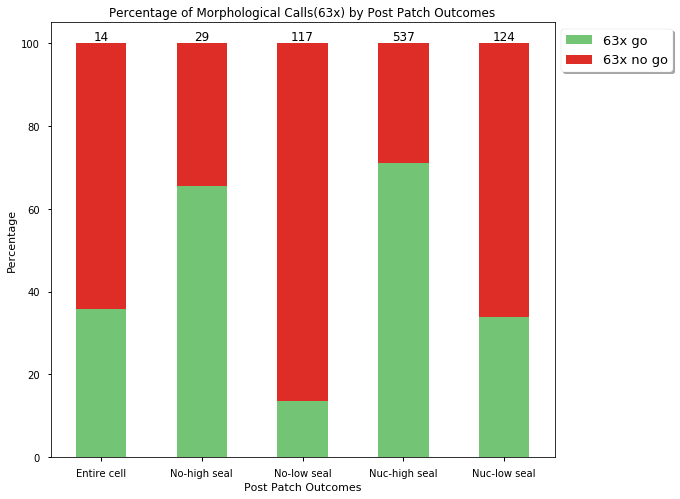

In [12]:
#order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal', 'Entire cell']
#.loc[order] lets you choose the order

my_colors = ['#74c476', '#de2d26']
bp = final_df1.plot.bar(stacked = True, 
                        color = my_colors, 
                        figsize= (10,8),
                        rot = 0)

bp.legend(['63x go', '63x no go'],
          loc = 0, 
          bbox_to_anchor = (1, 1), 
          frameon = True, 
          shadow = True,
          fontsize = 13)

plt.subplots_adjust(left = 0.1, right = 0.8, bottom = None, top = None, wspace=None, hspace=None)
#This helps if axis labels are getting cutoff when saving final image

#Rusty's Method figure it out later
rects = bp.patches
labels = post_patch_totals

#Rusty's Method figure it out later
for rect, label in zip (rects, labels):
    height = 100
    x_value = rect.get_x() + rect.get_width() / 2
    bp.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', size = 12)

bp.set_title('Percentage of Morphological Calls(63x) by Post Patch Outcomes')
bp.set(xlabel = 'Post Patch Outcomes', ylabel = 'Percentage')
plt.savefig('Stacked_Percentage_Barplot_M_by_PP')

[Text(0,0.5,'Post Patch Outcomes'), Text(0.5,0,'Percentage')]

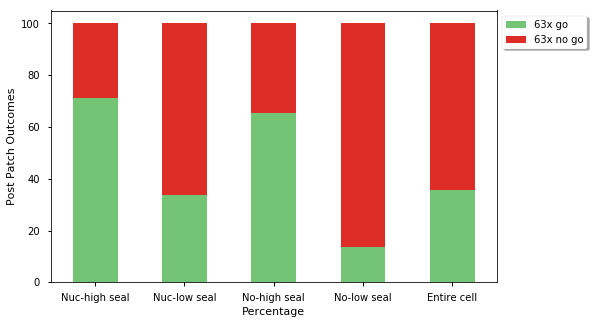

In [13]:
order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal', 'Entire cell']
#.loc[order] lets you choose the order

my_colors = ['#74c476', '#de2d26']
bp = final_df1.loc[order].plot.bar(stacked = True, 
                    color = my_colors,
                    figsize= (8,5),
                    rot = 0)

bp.legend(['63x go', '63x no go'],
          loc = 0, 
          bbox_to_anchor = (1, 1), 
          frameon = True, 
          shadow = True,
          fontsize = 10)

bp.set(xlabel = 'Percentage', ylabel = 'Post Patch Outcomes')